In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader, random_split
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision.models as models
from torchvision import datasets, transforms, utils
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import gc
import time
import copy
import os
import sys
import tqdm
from PIL import Image
import json
import requests
from collections import OrderedDict
from efficientnet_pytorch import EfficientNet
from grad_cam import GradCam, GuidedBackpropReLUModel, show_cams, show_gbs, preprocess_image
import ttach as tta


In [3]:
# Define transformations for the training data and validation data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load 
dataset = datasets.ImageFolder(root='train', transform=transform)

# Split 
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloaders  
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



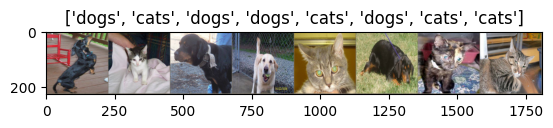

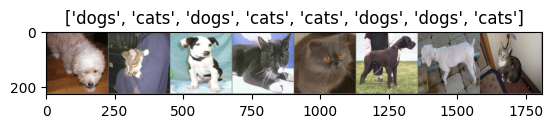

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

train_images, train_labels = next(iter(train_loader))

train_imagess = train_images[:8]
train_labelss = train_labels[:8]

out = utils.make_grid(train_imagess)

imshow(out, title=[dataset.classes[x] for x in train_labelss])

val_images, val_labels = next(iter(val_loader))

val_imagess = val_images[:8]
val_labelss = val_labels[:8]

out = utils.make_grid(val_imagess)

imshow(out, title=[dataset.classes[x] for x in val_labelss])

plt.show()


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load VGG19 
vgg19 = models.vgg19(pretrained=True)

# Modify the final layer 
vgg19.classifier[6] = torch.nn.Linear(vgg19.classifier[6].in_features, 2)
vgg19 = vgg19.to(device)

# loss function 
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg19.parameters(), lr=0.001, momentum=0.9)

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


Using device: cuda


/home/chungnguyen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chungnguyen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Train the model
num_epochs = 2
best_model_wts = copy.deepcopy(vgg19.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            vgg19.train()  # training mode
            dataloader = train_loader
        else:
            vgg19.eval()   # evaluate mode
            dataloader = val_loader
        
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = vgg19(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(vgg19.state_dict())

    print()

print('Training complete')
print(f'Best val Acc: {best_acc:4f}')

# Save the best model weights 
torch.save(best_model_wts, 'best_model_weights_vgg19.pth')

Epoch 1/2
----------
train Loss: 0.0418 Acc: 0.9833
val Loss: 0.0313 Acc: 0.9892

Epoch 2/2
----------
train Loss: 0.0130 Acc: 0.9953
val Loss: 0.0441 Acc: 0.9850

Training complete
Best val Acc: 0.989200


In [8]:
# Load the best model weights 
best_model_wts = torch.load('best_model_weights_vgg19.pth')

vgg19 = models.vgg19(pretrained=True)

vgg19.classifier[6] = torch.nn.Linear(vgg19.classifier[6].in_features, 2)

vgg19.load_state_dict(best_model_wts)
model = vgg19

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    inputs = preprocessed_img.requires_grad_(True)
    return inputs

grad_cam = GradCam(model=model, blob_name='features', target_layer_names=['36'], use_cuda=device.type == 'cuda')

img = cv2.imread('./test1/2.jpg', 1)

img = np.float32(cv2.resize(img, (224, 224))) / 255
inputs = preprocess_image(img).to(device)  # Move input to the same device as model

inputs.retain_grad()

target_index = 0


#  Grad-CAM et GB
mask_dic = grad_cam(inputs, target_index)
show_cams(img, mask_dic)
gb_model = GuidedBackpropReLUModel(model=model, activation_layer_name='ReLU', use_cuda=device.type == 'cuda')
show_gbs(inputs, gb_model, target_index, mask_dic)

In [10]:
import torch
import cv2
import numpy as np
from torchvision import models, transforms
from efficientnet_pytorch import EfficientNet
from grad_cam import GradCam, GuidedBackpropReLUModel, show_cams, show_gbs, preprocess_image
from PIL import Image

# Load the best model weights
best_model_wts = torch.load('best_model_weights.pth')

# Initialize the VGG19 model
vgg19 = models.vgg19(pretrained=True)
vgg19.classifier[6] = torch.nn.Linear(vgg19.classifier[6].in_features, 2)
vgg19.load_state_dict(best_model_wts)
model = vgg19

# Set device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Preprocess image using torchvision transforms
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
img_path = './test1/2.jpg'
img = cv2.imread(img_path, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = np.float32(cv2.resize(img, (224, 224))) / 255
img_tensor = preprocess(img).unsqueeze(0).to(device)

# Enable gradient calculation for input tensor
img_tensor.requires_grad = True  # Fix: Enable gradient calculation for the input

# Grad-CAM setup: target a deeper layer
grad_cam = GradCam(model=model, blob_name='features', target_layer_names=['34'], use_cuda=device.type == 'cuda')

# Get prediction for the image
model.eval()  # Switch model to evaluation mode
outputs = model(img_tensor)
_, predicted = outputs.max(1)
target_index = predicted.item()

# Generate Grad-CAM mask
mask_dic = grad_cam(img_tensor, target_index)

# Display Grad-CAM results
show_cams(img, mask_dic)

# Guided Backpropagation setup
gb_model = GuidedBackpropReLUModel(model=model, activation_layer_name='ReLU', use_cuda=device.type == 'cuda')

# Display Guided Backpropagation results
show_gbs(img_tensor, gb_model, target_index, mask_dic)
